In [7]:
from Data_Preprocessing import exp_var, hate_crime, hate_crime_combined, hc_by_year, region_grouped, race_grouped, indexed_df

import pandas as pd
import numpy as np
from datetime import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [8]:
indexed_df.head()

,TOTAL_INCIDENTS
INCIDENT_MONTH,
1991-01-31,302
1991-02-28,287
1991-03-31,287
1991-04-30,309
1991-05-31,371


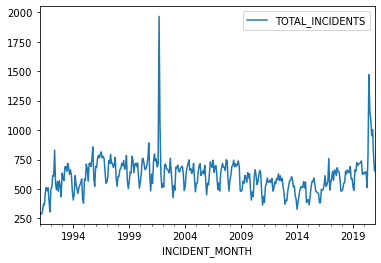

,TOTAL_INCIDENTS
INCIDENT_MONTH,
2001-09-30,1966
2001-10-31,1048
2020-06-30,1470
2020-07-31,1155
2020-08-31,1085
2020-10-31,1004


In [9]:
indexed_df.plot()
plt.show()

indexed_df[indexed_df['TOTAL_INCIDENTS'] > 1000]

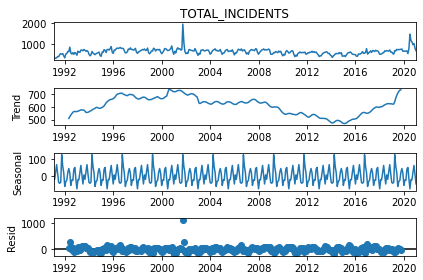

In [10]:
decompose_data = seasonal_decompose(indexed_df['TOTAL_INCIDENTS'], period=30)

decompose_plot = decompose_data.plot()

## trend is not consistent
##variation in residuals mostly accounted for in 2001 spike

<AxesSubplot:xlabel='INCIDENT_MONTH'>

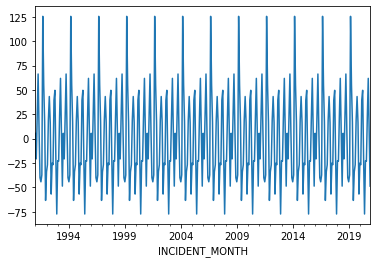

In [13]:
#inspect seasonality
seasonality = decompose_data.seasonal
seasonality.plot()

In [14]:
#Augmented Dickey Fuller test

dftest = adfuller(indexed_df.TOTAL_INCIDENTS, autolag = 'AIC')
print("ADF: ",dftest[0])
print("P-Value: ", dftest[1])
print("Num Of Lags: ", dftest[2])
print("Num Of Observations:", dftest[3])
print("Critical Values:")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
    
## p-value is high, well above threshold of 0.05
##dataset is non-stationary

ADF:  -2.0917595135766973
P-Value:  0.24784102700270688
Num Of Lags:  14
Num Of Observations: 345
Critical Values:
	 1% :  -3.4494474563375737
	 5% :  -2.8699542285903887
	 10% :  -2.5712527305187987


<AxesSubplot:title={'center':'original'}, xlabel='INCIDENT_MONTH'>

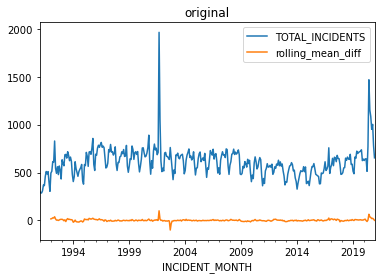

In [15]:
## use rolling mean as differencing method to impose stationarity

rolling_mean = indexed_df['TOTAL_INCIDENTS'].rolling(window = 12).mean()
indexed_df['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()

#plot original df and rolling mean difference together
indexed_df[['TOTAL_INCIDENTS', 'rolling_mean_diff']].plot(title='original')

In [16]:
#perform Augmented Dickey Fuller Test again on rolling_mean_diff

dftest = adfuller(indexed_df['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("ADF: ",dftest[0])
print("P-Value: ", dftest[1])
print("Num Of Lags: ", dftest[2])
print("Num Of Observations:", dftest[3])
print("Critical Values:")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
    
## p value is much lower than 0.05 now; stationarity has been corrected

ADF:  -5.707662573429253
P-Value:  7.423714163556169e-07
Num Of Lags:  12
Num Of Observations: 335
Critical Values:
	 1% :  -3.4500219858626227
	 5% :  -2.870206553997666
	 10% :  -2.571387268879483


### ACF and PACF

In [22]:
indexed_df

,TOTAL_INCIDENTS,rolling_mean_diff
INCIDENT_MONTH,,
1991-01-31,302,NaN
1991-02-28,287,NaN
1991-03-31,287,NaN
1991-04-30,309,NaN
1991-05-31,371,NaN
...,...,...
2020-08-31,1085,30.666667
2020-09-30,952,19.083333
2020-10-31,1004,22.166667


In [19]:
#confidence interval
ci = 1.96/np.sqrt(len(indexed_df))
ci

0.10330107023216706

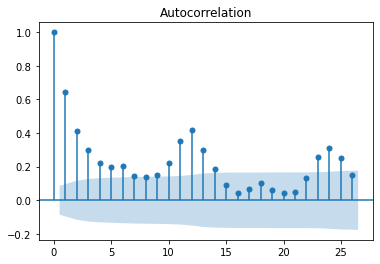

In [24]:
#ACF  (q value)
acf_array = acf(indexed_df['TOTAL_INCIDENTS'], fft=False)
plot_acf(indexed_df['TOTAL_INCIDENTS'], lags=26, alpha=ci)
plt.show()

#q=6

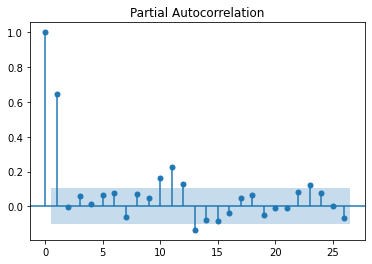

In [25]:
#PACF (p value)
plot_pacf(indexed_df['TOTAL_INCIDENTS'], lags = 26)
plt.show()

#p=3/4

## ARIMA

In [26]:
#p = lags in the autoregresive model
p = 5
#d = differencing / integration order
d = 1
#q = moving average lags
q = 4

my_order=(p,d,q)

#Seasonal order
# P = 
# D = 
# Q = 
# m = 

# my_seasonal_order = (P,D,Q,m)

In [27]:
model = ARIMA(indexed_df['TOTAL_INCIDENTS'], order=my_order)
results = model.fit()
results.summary()

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Like

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        TOTAL_INCIDENTS   No. Observations:                  360
Model:                 ARIMA(5, 1, 4)   Log Likelihood               -2198.718
Date:                Sat, 05 Mar 2022   AIC                           4417.436
Time:                        16:57:51   BIC                           4456.270
Sample:                    01-31-1991   HQIC                          4432.879
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3700      0.131    -10.430      0.000      -1.627      -1.113
ar.L2         -0.8459      0.193     -4.382      0.000      -1.224      -0.468
ar.L3         -0.0431      0.170     -0.253      0.800      -0.376       0.290
ar.L4          0.2645      0.131      2.020      0.043       0.008       0.521
ar.L5         -0.1466      0.062     -2.358      0.018      -0.268      -0.025
ma.L1          1.0110      0.135      7.476      0.000       0.746       1.276
ma.L2          0.0442      0.143      0.310      0.757      -0.235       0.324
ma.L3         -0.7966      0.134     -5.948      0.000      -1.059      -0.534
ma.L4         -0.7835      0.117     -6.687      0.000      -1.013      -0.554
sigma2      1.181e+04    322.859     36.578      0.000    1.12e+04    1.24e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             36116.16
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             4.44
Prob(H) (two-sided):                  0.13   Kurtosis:                        51.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='INCIDENT_MONTH'>

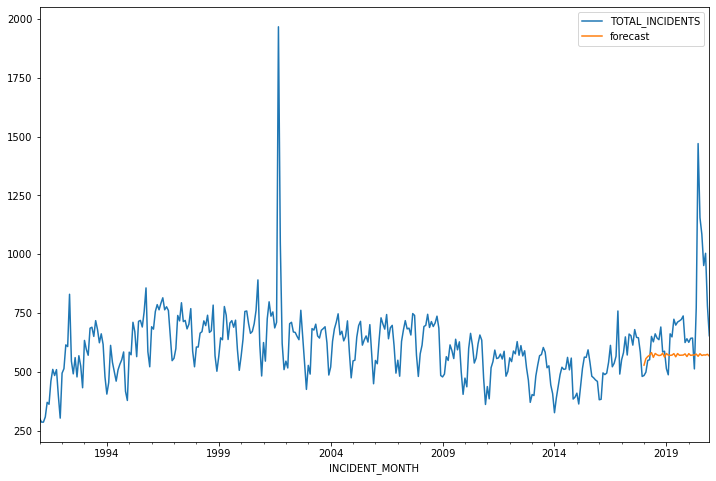

In [28]:
indexed_df['forecast'] = results.predict(start='2018-01', end='2020-12', dynamic=True)
indexed_df[['TOTAL_INCIDENTS', 'forecast']].plot(figsize=(12,8))

## SARIMAX

In [31]:
model = SARIMAX(indexed_df['TOTAL_INCIDENTS'], order=my_order, seasonal_order=(1,1,1,12))
results = model.fit()

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\base\model.py:566: C

C:\Users\aspen\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<AxesSubplot:xlabel='INCIDENT_MONTH'>

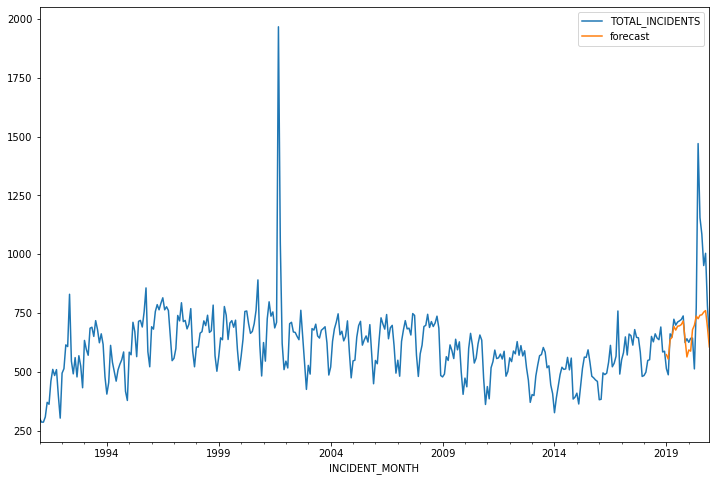

In [32]:
indexed_df['forecast']=results.predict(start='2019-01',end='2020-12',dynamic=True)
indexed_df[['TOTAL_INCIDENTS','forecast']].plot(figsize=(12,8))